In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import string
import theano
import therapy
import importlib
import itertools

sns.set()
plt.ion()

idx = pd.IndexSlice

# 8 Markov Chain Monte Carlo

## 8.1. Good King Markov and His island kingdom

In [87]:
# Code 8.1
rs = np.random.RandomState(seed=42)
num_weeks = 100000

positions = np.zeros(num_weeks, dtype=int)

current = 10

for i in range(len(positions)):
    # record current position
    positions[i] = current

    # flip coin to generate a proposal
    proposal = current + rs.choice([-1, 1])

    # now make sure he loops around the archipelago
    if proposal < 1:
        proposal = 10

    if proposal > 10:
        proposal = 1

    # move?
    prob_move = proposal / current

    current = proposal if rs.uniform() < prob_move else current

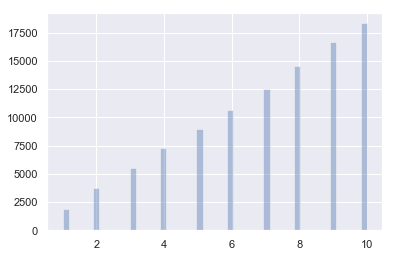

In [90]:
sns.distplot(positions, kde=False)

# change of pace
from here on will only do exercises

## 8.6 Practice

**Easy**

### 8E1.

(1) No, samples may also be continuous

(2) Unsure what 'likelihood function' means in this specific case. If it means likelihood function of data given hypothesis, then no, this is not a requirement either.

(3) Yes, the proposal distribution must be symmetric

### 8E2.
Gibbs sampling is more efficient, i.e. can generate an image of the posterior that is just as good as the simple Metropolis algorithm in fewer samples, by allowing for an asymmetrical proposal distribution, and by using adaptive proposals. The distribution of proposes parameters then depends on current parameter values through using conjugate prior/likelihood combinations. These conjugate pairs have analytical solutions for posterior distributions of individual parameters, which can be used to make more efficient jumps around the joint posterior of all parameters.

On the flipside, Gibbs sampling only works for conjugate pairs, even though these combinations of prior and likelihood might not make the most sense for a model. Furthermore, Gibbs sampling can become very inefficient for large models with many parameters

### 8E3.
Hamiltonian Monte Carlo can only handle continuous parameters, as it essentially simulates a frictionless particle gliding over parameter space. It can't glide over non-continuous space. As a consequence, it can't be used in some scenarios, e.g. imputation of discrete missing data.

### 8E4.
n_eff is an estimate of the number of independent samples. I'm not sure how that differs from the actual number of samples. My guess is that only independent samples really tell us something about the posterior?

### 8E5.
Rhat should approach 1 from above if a chain is sampling the posterior correctly.

### 8E6.
Looking for stationarity and good mixing. Stationarity: path stays within posterior. Mean value of chain stable beggining to end. Well-mixing: consecutive values not highly correlated. Visually indicated by rapid zig-zagging.


[good plot]
[bad plot]

**Medium**

### 8M1.

In [13]:
d = (
    pd
    .read_csv('./data/rugged.csv', sep=';')
    .set_index('isocode')
    .assign(log_gdp=lambda df: np.log(df['rgdppc_2000']))
)

d.head()

,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,lon,...,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp
isocode,,,,,,,,,,,,,,,,,,,,,
ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,-69.970,...,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN,NaN
AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,66.026,...,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0,NaN
AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,17.551,...,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0,7.492609
AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,-63.064,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,20.070,...,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0,8.216929


In [47]:
d.shape

(234, 51)

In [48]:
dd = d.dropna(subset=["rgdppc_2000"])

In [49]:
dd.shape

(170, 51)

In [55]:
with pm.Model() as m:
    data = dd
    shared = therapy.create_theano_shared_from_df(data)
    pm.HalfCauchy('sigma', 2)
    pm.Normal('bAR', 0, 10)
    pm.Normal('bA', 0, 10)
    pm.Normal('bR', 0, 10)
    pm.Normal('a', 0, 100)
    pm.Deterministic(
        'mu', 
        m.a 
        + m.bR * shared['rugged'] 
        + m.bA * shared['cont_africa']
        + m.bAR * shared['cont_africa'] * shared['rugged']
    )
    pm.Normal('log_gdp', m.mu, m.sigma, observed=shared['log_gdp'])

m_8_1 = therapy.Model(m, shared, 'm_8_1')

m_8_1.fit()

therapy.interesting_summary(m_8_1).sort_index()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 557.94draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.226120,0.141728,0.006971,8.920120,9.481871,375.905557,0.999277
bA,-1.954303,0.216797,0.010523,-2.422787,-1.557999,418.134250,0.999910
bAR,0.398612,0.121295,0.005775,0.146390,0.628339,458.882804,0.999887
bR,-0.206232,0.078177,0.003703,-0.353199,-0.057766,425.742208,0.999258
sigma,0.952154,0.050568,0.001814,0.861035,1.057677,742.128092,0.999550


In [61]:
with pm.Model() as m:
    data = dd
    shared = therapy.create_theano_shared_from_df(data)
    pm.Uniform('sigma', 0, 10)
    pm.Normal('bAR', 0, 10)
    pm.Normal('bA', 0, 10)
    pm.Normal('bR', 0, 10)
    pm.Normal('a', 0, 100)
    pm.Deterministic(
        'mu', 
        m.a 
        + m.bR * shared['rugged'] 
        + m.bA * shared['cont_africa']
        + m.bAR * shared['cont_africa'] * shared['rugged']
    )
    pm.Normal('log_gdp', m.mu, m.sigma, observed=shared['log_gdp'])

m_8m1unif = therapy.Model(m, shared, 'm_8m1unif')

m_8m1unif.fit()

therapy.interesting_summary(m_8m1unif).sort_index()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 472.68draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.228150,0.145182,0.006763,8.948083,9.500981,394.380268,1.002030
bA,-1.957342,0.224348,0.009816,-2.404717,-1.538572,427.674135,0.999608
bAR,0.395113,0.131633,0.005846,0.136900,0.651283,407.909690,1.001617
bR,-0.202744,0.079375,0.003624,-0.367422,-0.064187,400.881606,1.004477
sigma,0.949854,0.053220,0.001862,0.849570,1.065048,911.260267,0.999000


In [60]:
with pm.Model() as m:
    data = dd
    shared = therapy.create_theano_shared_from_df(data)
    pm.Exponential('sigma', 1)
    pm.Normal('bAR', 0, 10)
    pm.Normal('bA', 0, 10)
    pm.Normal('bR', 0, 10)
    pm.Normal('a', 0, 100)
    pm.Deterministic(
        'mu', 
        m.a 
        + m.bR * shared['rugged'] 
        + m.bA * shared['cont_africa']
        + m.bAR * shared['cont_africa'] * shared['rugged']
    )
    pm.Normal('log_gdp', m.mu, m.sigma, observed=shared['log_gdp'])

m_8m1exp = therapy.Model(m, shared, 'm_8m1exp')

m_8m1exp.fit()

therapy.interesting_summary(m_8m1exp).sort_index()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 405.55draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.221115,0.144071,0.007104,8.955179,9.495077,386.056829,0.999109
bA,-1.947529,0.226487,0.012278,-2.408975,-1.520156,313.535998,0.999457
bAR,0.391621,0.136015,0.007008,0.134606,0.652506,360.705388,0.999019
bR,-0.201967,0.076968,0.003828,-0.339865,-0.040557,381.029686,0.999364
sigma,0.947332,0.053940,0.001921,0.834948,1.049468,725.615374,1.003287


so are inferences actually any different?

In [62]:
models = [m_8_1, m_8m1exp, m_8m1unif]

In [64]:
summaries = [therapy.interesting_summary(m) for m in models]
joined = pd.concat(summaries, keys=[m.name for m in models])
joined

In [99]:
sliced = joined.loc[idx[:, 'sigma'], :]
sliced

In [132]:
yerr = np.abs(sliced['mean'].values[:, np.newaxis] - sliced[['hpd_2.5', 'hpd_97.5']].values).T
sns.barplot(x=sliced.index, y='mean', data=sliced)
plt.errorbar(x=range(len(sliced)), y='mean', yerr=yerr, data=sliced, fmt='none');

doesn't look like there's any measurable difference

### 8M2.

investigate of making half cauchy prior stronger

In [136]:
scaling_vals = np.linspace(0.1, 2, 5)

In [143]:
def train_cauchy(sv):
    with pm.Model() as m:
        data = dd
        shared = therapy.create_theano_shared_from_df(data)
        pm.HalfCauchy('sigma', sv)
        pm.Normal('bAR', 0, 10)
        pm.Normal('bA', 0, 10)
        pm.Normal('bR', 0, 10)
        pm.Normal('a', 0, 100)
        pm.Deterministic(
            'mu', 
            m.a 
            + m.bR * shared['rugged'] 
            + m.bA * shared['cont_africa']
            + m.bAR * shared['cont_africa'] * shared['rugged']
        )
        pm.Normal('log_gdp', m.mu, m.sigma, observed=shared['log_gdp'])

    m_8m2cauchy = therapy.Model(m, shared, f'm_8m2cauchy_{sv}')
    m_8m2cauchy.fit()
    
    return m_8m2cauchy

In [146]:
cauchy_models = [train_cauchy(sv) for sv in scaling_vals]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:06<00:00, 245.47draws/s]
The acceptance probability does not match the target. It is 0.9265251754828105, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 478.46draws/s]
The acceptance probability does not match the target. It is 0.9072182704038825, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 452.59draws/s]
Auto-assigning NUTS samp

what's the impact on the estimate of sigma?

In [151]:
summaries = [therapy.interesting_summary(m) for m in cauchy_models]
joined = pd.concat(summaries, keys=[m.name for m in cauchy_models])
joined

mean        sd  mc_error   hpd_2.5  hpd_97.5  \
m_8m2cauchy_0.1   bAR    0.389836  0.131535  0.005548  0.128631  0.642655   
                  bA    -1.944831  0.228643  0.010796 -2.375652 -1.486329   
                  bR    -0.200514  0.078927  0.003509 -0.354840 -0.047658   
                  a      9.223363  0.141523  0.006675  8.935722  9.492391   
                  sigma  0.945345  0.051393  0.001816  0.850290  1.043895   
m_8m2cauchy_0.575 bAR    0.395308  0.128780  0.006145  0.135959  0.639537   
                  bA    -1.956124  0.229788  0.011242 -2.451784 -1.536048   
                  bR    -0.200680  0.076900  0.003551 -0.343136 -0.052553   
                  a      9.223407  0.139434  0.006563  8.966996  9.506774   
                  sigma  0.946981  0.053451  0.001980  0.844736  1.049491   
m_8m2cauchy_1.05  bAR    0.381252  0.140900  0.006739  0.101915  0.665754   
                  bA    -1.919257  0.249120  0.012346 -2.423939 -1.437293   
                  bR    -0.198830  0.081488  0.003961 -0.359279 -0.041502   
                  a      9.212195  0.147161  0.007027  8.935188  9.503561   
                  sigma  0.951098  0.053701  0.001905  0.848575  1.055958   
m_8m2cauchy_1.525 bAR    0.403079  0.128785  0.005727  0.145705  0.641844   
                  bA    -1.959463  0.217961  0.009346 -2.411656 -1.578149   
                  bR    -0.204296  0.076762  0.003462 -0.361200 -0.062798   
                  a      9.228931  0.140095  0.006432  8.970771  9.491740   
                  sigma  0.953434  0.050502  0.001856  0.859440  1.057901   
m_8m2cauchy_2.0   bAR    0.401698  0.133042  0.006004  0.152078  0.675675   
                  bA    -1.960271  0.234922  0.010981 -2.434994 -1.536732   
                  bR    -0.205017  0.076098  0.003910 -0.351674 -0.067827   
                  a      9.225848  0.140021  0.007322  8.946502  9.485753   
                  sigma  0.948072  0.050402  0.001573  0.853134  1.049516   

                              n_eff      Rhat  
m_8m2cauchy_0.1   bAR    465.577162  0.999000  
                  bA     367.889357  0.999033  
                  bR     444.783410  0.999063  
                  a      402.772732  0.999012  
                  sigma  817.522603  0.999332  
m_8m2cauchy_0.575 bAR    385.154538  1.000047  
                  bA     358.437679  1.003828  
                  bR     387.109790  1.001063  
                  a      346.720189  1.001284  
                  sigma  660.617223  0.999208  
m_8m2cauchy_1.05  bAR    350.475540  0.999115  
                  bA     349.095572  0.999133  
                  bR     351.586292  0.999314  
                  a      389.402804  0.999253  
                  sigma  883.915465  0.999772  
m_8m2cauchy_1.525 bAR    484.134837  0.999486  
                  bA     492.258138  1.000446  
                  bR     425.861918  0.999064  
                  a      441.271263  0.999731  
                  sigma  702.711074  0.999075  
m_8m2cauchy_2.0   bAR    358.142587  1.011558  
                  bA     388.905532  1.006877  
                  bR     247.237644  1.011718  
                  a      244.309266  1.012899  
                  sigma  978.443906  0.999249

In [153]:
sliced = joined.loc[idx[:, 'sigma'], :]
sliced

,,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m_8m2cauchy_0.1,sigma,0.945345,0.051393,0.001816,0.850290,1.043895,817.522603,0.999332
m_8m2cauchy_0.575,sigma,0.946981,0.053451,0.001980,0.844736,1.049491,660.617223,0.999208
m_8m2cauchy_1.05,sigma,0.951098,0.053701,0.001905,0.848575,1.055958,883.915465,0.999772
m_8m2cauchy_1.525,sigma,0.953434,0.050502,0.001856,0.859440,1.057901,702.711074,0.999075
m_8m2cauchy_2.0,sigma,0.948072,0.050402,0.001573,0.853134,1.049516,978.443906,0.999249


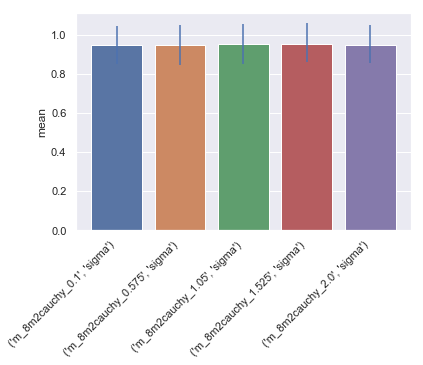

In [158]:
yerr = np.abs(sliced['mean'].values[:, np.newaxis] - sliced[['hpd_2.5', 'hpd_97.5']].values).T
sns.barplot(x=sliced.index, y='mean', data=sliced)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.errorbar(x=range(len(sliced)), y='mean', yerr=yerr, data=sliced, fmt='none');

In [162]:
cm = cauchy_models[0]

In [171]:
samples = cm.predict(sample_ppc_kwargs={'var_names': ['mu']})

100%|██████████| 1000/1000 [00:00<00:00, 1830.92it/s]


In [165]:
samples.head()

,log_gdp_samples,log_gdp_hpd_lower,log_gdp_hpd_upper,log_gdp_mean
0,"[7.738323598237185, 6.951501614583555, 7.22553...",6.559318,8.467345,7.502754
1,"[8.976051531760557, 8.161292142625515, 8.12518...",7.579527,9.571359,8.548505
2,"[9.17784618793184, 8.758424355320514, 9.502734...",7.947210,9.898514,9.052885
3,"[9.054488918033579, 9.827635588543982, 8.71627...",8.108370,10.034513,9.034020
4,"[8.960670632930004, 7.8628843676895075, 8.8367...",7.839302,9.794676,8.746786


In [168]:
samples.log_gdp_samples.iloc[0].shape

(1000,)